In [2]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble, metrics
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### Read data

In [3]:
train = pd.read_csv('/Users/Olga.Lavrichenko/Documents/ВШЭ/recomend_system/data/train.csv')

In [4]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [5]:
songs = pd.read_csv('/Users/Olga.Lavrichenko/Documents/ВШЭ/recomend_system/data/songs.csv')
song_extra = pd.read_csv('/Users/Olga.Lavrichenko/Documents/ВШЭ/recomend_system/data/song_extra_info.csv')
members = pd.read_csv('/Users/Olga.Lavrichenko/Documents/ВШЭ/recomend_system/data/members.csv')

### Merge

In [6]:
train = pd.merge(train, songs, on='song_id', how='left')
train = pd.merge(train, song_extra, on='song_id', how='left')
train = pd.merge(train, members, on='msno', how='left')
del train['song_id']
del train['msno']
train.head()

,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,20110525,20170911
2,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


In [7]:
def sum_value(df):
    for i in df.columns.values:
        print(i)
        print(df[i].value_counts())
        print(df[i].isna().sum())
        print("______________________________________")
sum_value(train)

source_system_tab
my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
notification       6185
settings           2200
Name: source_system_tab, dtype: int64
24849
______________________________________
source_screen_name
Local playlist more     3228202
Online playlist more    1294689
Radio                    474467
Album more               420156
Search                   298487
Artist more              252429
Discover Feature         244246
Discover Chart           213658
Others profile more      201795
Discover Genre            82202
My library                75980
Explore                   72342
Unknown                   54170
Discover New              15955
Search Trends             13632
Search Home               13482
My library_Search          6451
Self profile more           212
Concert                      47
Payment                      12
Name: source_screen_name, dtype: int64
414804
__

In [8]:
train=train.dropna()
sum_value(train)

source_system_tab
my library      1155742
discover         620454
search           172567
radio            107160
listen with       95579
explore           45549
notification       1913
settings            291
Name: source_system_tab, dtype: int64
0
______________________________________
source_screen_name
Local playlist more     1072657
Online playlist more     412472
Radio                    108203
Album more               106488
Others profile more       94780
Discover Chart            76926
Discover Feature          75852
Artist more               74884
Search                    73960
My library                25681
Explore                   23486
Unknown                   19164
Discover Genre            16635
Discover New               6233
Search Home                5053
Search Trends              4370
My library_Search          2351
Self profile more            49
Concert                       6
Payment                       5
Name: source_screen_name, dtype: int64
0
___________

In [9]:
train.shape

(2199255, 18)

### Prepare 

In [10]:
train['registration_init_time'] = pd.to_datetime(train['registration_init_time'], format='%Y%m%d', errors='ignore')
train['expiration_date'] = pd.to_datetime(train['expiration_date'],  format='%Y%m%d', errors='ignore')

In [11]:
train['registration_init_time_year'] = train['registration_init_time'].dt.year
train['registration_init_time_month'] = train['registration_init_time'].dt.month

train['expiration_date_year'] = train['expiration_date'].dt.year
train['expiration_date_month'] = train['expiration_date'].dt.month

del train['registration_init_time']
del train['expiration_date']

In [12]:
train.head()

,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time_year,registration_init_time_month,expiration_date_year,expiration_date_month
6,my library,Local playlist more,local-playlist,1,229982.0,465,BIGBANG TAEYANG,TEDDY| DEE.P| Rebecca Johnson,TEDDY| TAEYANG,31.0,眼| 鼻| 口 (Eyes| Nose| Lips),TWA531400512,13,24,female,9,2011,5,2017,9
11,my library,Local playlist more,local-library,1,224597.0,465,嚴爵 (Yen-j),嚴爵,嚴爵,3.0,輕輕 (Lightly),TWK231507907,15,26,male,9,2011,11,2018,3
19,my library,Local playlist more,local-library,1,241975.0,465,孫燕姿 (Yanzi Sun),Li Wei Song,Xiao Han,3.0,雨天 (雨天),TWA530617601,9,27,female,9,2013,9,2017,9
21,my library,Local playlist more,local-library,1,247911.0,465,莫文蔚 (Karen Mok),Skot Suyama,李焯雄,3.0,愛死你,TWA470326002,9,27,female,9,2013,9,2017,9
32,my library,Local playlist more,local-library,1,210048.0,1259,蛋堡 (Soft Lipa),杜振熙,杜振熙/（OT：白鴿）伍佰,3.0,史詩,TWI451300037,13,34,male,9,2010,8,2017,9


In [13]:
columns_not_categorical = ['expiration_date_year', 'expiration_date_month', 'registration_init_time_year', 'registration_init_time_month', 'registered_via','song_length', 'city', 'language', 'target', 'genre_ids', 'bd']

In [14]:
columns_not_categorical

['expiration_date_year',
 'expiration_date_month',
 'registration_init_time_year',
 'registration_init_time_month',
 'registered_via',
 'song_length',
 'city',
 'language',
 'target',
 'genre_ids',
 'bd']

In [14]:
from tqdm import tqdm 

In [15]:
col=list(train.columns)

In [16]:
col

['source_system_tab',
 'source_screen_name',
 'source_type',
 'target',
 'song_length',
 'genre_ids',
 'artist_name',
 'composer',
 'lyricist',
 'language',
 'name',
 'isrc',
 'city',
 'bd',
 'gender',
 'registered_via',
 'registration_init_time_year',
 'registration_init_time_month',
 'expiration_date_year',
 'expiration_date_month']

In [15]:
# for i in tqdm(col):
#     print(i)
#     if i not in columns_not_categorical:
#         dict_=train[i].value_counts()
#         new_data = {k: v for k, v in train[i].value_counts().items() if  v <= train.shape[0]*0.01}

#         train = pd.concat([train,pd.get_dummies(train[i], prefix=i)],axis=1)
#         del train[i]
#         for elem in new_data:
#             del train[i+"_"+elem]
        

In [16]:
for col in train.select_dtypes(include=['object']).columns:
    train[col] = train[col].astype('category')
    
for col in train.select_dtypes(include=['category']).columns:
    train[col] = train[col].cat.codes

In [17]:
train.head()

,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time_year,registration_init_time_month,expiration_date_year,expiration_date_month
6,3,8,4,1,229982.0,146,415,16596,15300,31.0,40570,30335,13,24,0,9,2011,5,2017,9
11,3,8,3,1,224597.0,146,5663,20165,18916,3.0,43901,39846,15,26,1,9,2011,11,2018,3
19,3,8,3,1,241975.0,146,5773,11039,16618,3.0,45306,29656,9,27,0,9,2013,9,2017,9
21,3,8,3,1,247911.0,146,6792,15987,20625,3.0,34175,27930,9,27,0,9,2013,9,2017,9
32,3,8,3,1,210048.0,41,6895,21674,20709,3.0,28887,38571,13,34,1,9,2010,8,2017,9


In [18]:
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(train[train.columns[train.columns != 'target']], train.target)

RandomForestClassifier(max_depth=25, n_estimators=250)

In [21]:
df_plot = pd.DataFrame({'features': train.columns[train.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

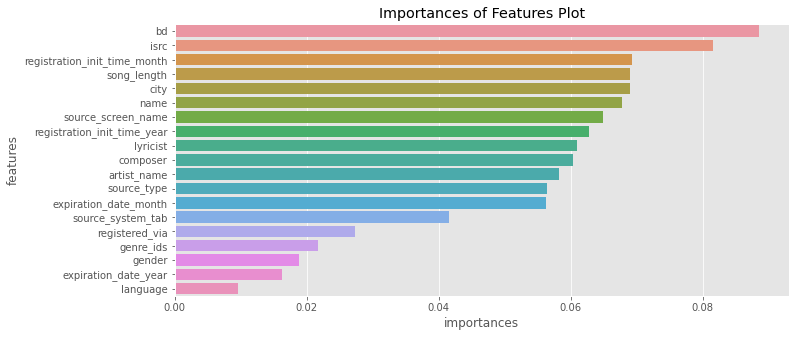

In [22]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [25]:
target = train.pop('target')
train_data, test_data, train_labels, test_labels = train_test_split(train, target, test_size = 0.3)

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0).fit(train_data, train_labels)